In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import jsonlines
from tqdm.auto import tqdm

def load_data(data_dir: os.PathLike) -> pd.DataFrame:
    lines = []
    for file in os.listdir(data_dir):
        if file.endswith(".jsonl"):
            with jsonlines.open(os.path.join(data_dir, file)) as reader:
                for obj in reader:
                    lines.append(obj)

    out_df = pd.DataFrame(lines)
    out_df["date"] = pd.to_datetime(out_df["date"].astype(int), unit="s")
    return out_df

all_shaders20k = load_data("./data/annotated")
all_api = load_data("./data/annotated/api")
df = pd.concat([all_shaders20k, all_api])
len(df)

27857

In [2]:
df["author"].value_counts().head(10)

author
FabriceNeyret2      832
jarble              470
dr2                 447
SnoopethDuckDuck    326
mrange              276
iq                  262
jorge2017a1         245
oneshade            211
jonasfrey           194
gaz                 187
Name: count, dtype: int64

In [3]:
# take a subset of the data for speed
# df = df.sample(1000, random_state=42)

# only keep rows where author is "iq" or "FabriceNeyret2"
df = df[df["author"].isin(["iq", "FabriceNeyret2"])]
len(df)

1094

In [4]:
def expand_functions(dataframe: pd.DataFrame) -> pd.DataFrame:
    # TODO: likely redundant, since we keep everything... might need some cleanup instead
    cols_to_keep = ["id", "date", "image_code", "functions", "func_bytes", "author", "license"]
    #function byte indicies: start_comment, start_header, end_header, end_docstring, end_function
    func_parts = ["comment", "header", "docstring", "body"]

    # TODO: do we need the whole functions for anything downstream?
    dataframe["functions_"] = dataframe["functions"] # make a copy to keep it past explode
    func_df = dataframe.explode("functions")
    func_df.rename(columns={"functions": "func_bytes", "functions_": "functions"}, inplace=True)
    func_df.dropna(subset=["func_bytes"], inplace=True) # some shaders got not functions parsed ? -> TODO: check the tree-sitter.has_error() result?
    func_df.reset_index(inplace=True)
    for row_idx, row in func_df.iterrows():
        # print(row_idx, row)
        # break
        code = row["image_code"]
        code_bytes = bytes(code, encoding="utf-8")
        # func_bytes = row["func_bytes"]
        for idx, part in enumerate(func_parts):
            start = row["func_bytes"][idx]
            end = row["func_bytes"][idx+1]
            func_df.at[row_idx, part] = code_bytes[start:end].decode(encoding="utf-8")
        
    func_df.drop(columns=func_df.columns.difference(cols_to_keep + func_parts), inplace=True)
    # func_df["date"] = pd.to_datetime(func_df["date"].astype(int), unit="s")

    return func_df
funcs = expand_functions(df)
len(funcs)

2622

In [5]:
funcs["header"].nunique() # 78256
funcs["id"].nunique() # 27857
# header_matrix = pd.crosstab(funcs['id'][:100], funcs['header'][:100])

1021

In [6]:
# Alternative 2: If you need to manually construct it
shader_ids = funcs['id'].unique()
function_headers = funcs['header'].unique()

# Create empty matrix
header_matrix = pd.DataFrame(
    0, 
    index=shader_ids,
    columns=function_headers
)

# Fill the matrix
for _, row in tqdm(funcs.iterrows(), total=len(funcs)):
    header_matrix.loc[row['id'], row['header']] = 1

  0%|          | 0/2622 [00:00<?, ?it/s]

In [7]:
# some clean up
print(header_matrix.sum(axis=0).value_counts().sort_index()[1:].sum()) # only 20380 functions that show up in multiple shaders!
header_matrix.drop(columns=header_matrix.columns[header_matrix.sum(axis=0) <= 2], inplace=True) # drop functions that don't coocur anyway
header_matrix.drop(index=header_matrix.index[header_matrix.sum(axis=1) <= 1], inplace=True) # drop shaders that only have a single function (main function)
header_matrix.drop(columns=header_matrix.columns[header_matrix.columns.str.startswith("void mainImage")], inplace=True)
print(header_matrix.shape)
# convert to uint8 matrix for space efficiency
header_matrix = header_matrix.astype(np.uint8)
# memory footprint
header_matrix.memory_usage().sum()

274
(216, 106)


np.int64(24624)

In [8]:
import scipy.sparse as sp

# Convert to sparse matrix
sparse_header = sp.csr_matrix(header_matrix.values)

# Perform the multiplication using sparse matrices
sparse_shared = sparse_header @ sparse_header.T

# remove the lower diagonal to avoid duplicates
sparse_shared = sp.triu(sparse_shared, k=1)

# Convert back to pandas if needed
shared_functions = pd.DataFrame(
    sparse_shared.toarray(), 
    index=header_matrix.index,
    columns=header_matrix.index
)

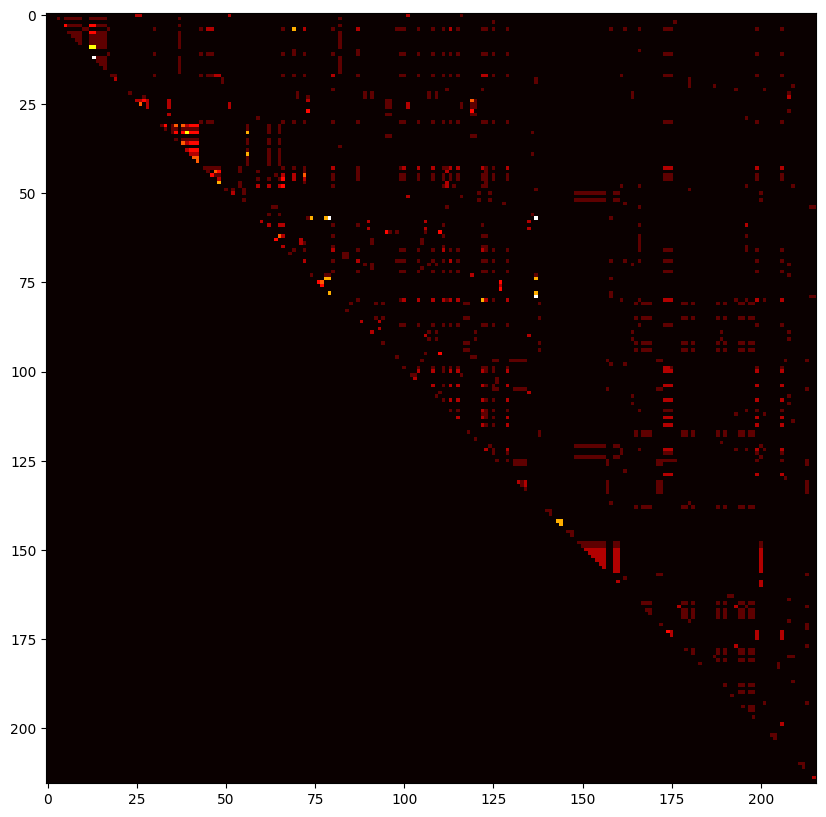

In [9]:
# show as image
plt.figure(figsize=(10, 10))
plt.imshow(shared_functions, interpolation="nearest", cmap="hot")
plt.show()

In [10]:
import networkx as nx
# import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# G = nx.from_scipy_sparse_array(sparse_shared.astype(int), create_using=nx.Graph)
G = nx.from_pandas_adjacency(shared_functions.astype(int), create_using=nx.Graph)
# G.remove_edges_from(nx.selfloop_edges(G))
len(G.edges)
# add node labels from dataframe index


1278

In [11]:
# Find largest connected component (if graph is fragmented)
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()
print(f"Largest component has {G_largest.number_of_nodes()} nodes and {G_largest.number_of_edges()} edges")# Basic network stats
print("Network statistics:")
print(f"Number of connected components: {nx.number_connected_components(G)}")
# print(f"Average clustering coefficient: {nx.average_clustering(G)}")
# print(f"Average path length: {nx.average_shortest_path_length(G_largest)}")  # Only on largest component

# Find most central nodes (shaders that share functions with many others)
centrality = nx.degree_centrality(G)
top_shaders = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nMost connected shaders:")
for shader, score in top_shaders:
    print(f"Shader {shader}: connected to {score:.4f} of network")

Largest component has 147 nodes and 961 edges
Network statistics:
Number of connected components: 16

Most connected shaders:
Shader 3ld3DM: connected to 0.1860 of network
Shader lsKcDD: connected to 0.1767 of network
Shader WdyXRD: connected to 0.1767 of network
Shader Ws3XWl: connected to 0.1581 of network
Shader 4lK3Rc: connected to 0.1535 of network
Shader wlj3zV: connected to 0.1535 of network
Shader 4sXXRN: connected to 0.1488 of network
Shader 4slSWf: connected to 0.1488 of network
Shader MtsSRf: connected to 0.1488 of network
Shader Md2BWW: connected to 0.1488 of network


In [12]:
list(G.edges(data=True))[:10]

[('ld23DV', '4djXDy', {'weight': 2}),
 ('ld23DV', '4sSXDV', {'weight': 2}),
 ('ld23DV', 'Ml3GR8', {'weight': 2}),
 ('ld23DV', 'WslGz4', {'weight': 2}),
 ('ld23DV', 'Wt2XzK', {'weight': 1}),
 ('ldBGDc', '4sfSR7', {'weight': 1}),
 ('ldBGDc', 'lsXXzN', {'weight': 1}),
 ('ldBGDc', 'MdsSRM', {'weight': 1}),
 ('ldBGDc', 'MsfXzM', {'weight': 1}),
 ('ldBGDc', 'XdsXz4', {'weight': 1})]

In [13]:
# find a smaller subgraph
def get_subgraph(G, min_size=5, max_size=400):
    for sg in nx.connected_components(G):
        if len(sg) > min_size and len(sg) < max_size:
            yield G.subgraph(sg)
        else:
            continue
    return None

subgraph_gen = get_subgraph(G)

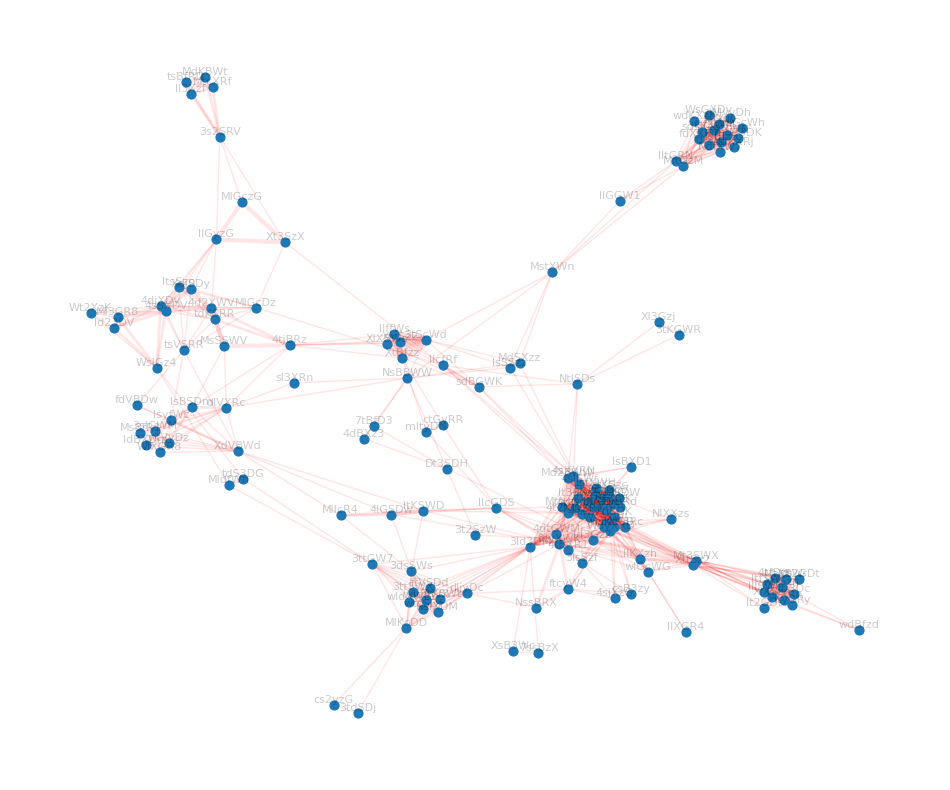

In [14]:
# subgraph = next(subgraph_gen)
subgraph = G_largest

# add direction by comparing publishing date of shaders
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subgraph)#, seed=42)
weight = [d["weight"] for _, _, d in subgraph.edges(data=True)]
nx.draw_networkx_edges(subgraph, pos, alpha=0.1, width=weight, edge_color="red", arrows=True, node_size=40, arrowsize=600)
nx.draw_networkx_nodes(subgraph, pos, node_size=40)
nx.draw_networkx_labels(subgraph, pos, font_size=8, verticalalignment="bottom", alpha=0.2)
plt.axis("off")
plt.show()

In [ ]:
all_pos = nx.random_layout(G, seed=42) # cheap way to initialize the positions

In [ ]:
from IPython.display import display, clear_output

fig, ax = plt.subplots(figsize=(8, 5))
for it in tqdm(range(50)):
    all_pos = nx.spring_layout(G, pos=all_pos, seed=42, iterations=1)
    
    clear_output(wait=True)  # Clear previous output but wait to replace it
    ax.clear()  # Clear the previous plot
    ax.scatter([x for x, y in all_pos.values()], [y for x, y in all_pos.values()], s=1)
    display(fig)  # Display the current figure
plt.close()

In [ ]:
kawai_pos = nx.kamada_kawai_layout(G) # takes more than 23 minutes :/ (so I gave up)

In [ ]:
plt.scatter([x for x, y in kawai_pos.values()], [y for x, y in kawai_pos.values()], s=1)
plt.show()

## interactive visualization with fastplotlib??

In [15]:
%gui qt

In [31]:
author_cols = {
    "iq": "blue",
    "FabriceNeyret2": "green"
}

In [ ]:
import fastplotlib as fpl

fig = fpl.Figure(size=(600,600))


links = []
weights = []
for edge in subgraph.edges(data=True):
    start, stop, data = edge
    weights.append(data["weight"])
    links.append(np.array([pos[start], pos[stop]], dtype=np.float32))
    # fig[0,0].add_line(np.array([pos[start], pos[stop]], dtype=np.float32), thickness=weight, colors=col, alpha=0.2)

edges = fig[0,0].add_line_collection(links, thickness=weights, alpha=0.2, cmap="jet")
nodes = fig[0,0].add_scatter(data=np.array(list(pos.values()),dtype=np.float32), sizes=20, cmap="") # does order matter?


# get the nearest graphic that is clicked and change the color
@fig.renderer.add_event_handler("click")
def click_event(ev):
    # reset colors
    edges.cmap = "jet"

    # map the click position to world coordinates
    xy = fig[0, 0].map_screen_to_world(ev)[:-1]

    # get the nearest graphic to the position
    nearest = fpl.utils.get_nearest_graphics(xy, edges)[0]

    # change the closest graphic color to white
    nearest.colors = "w"

# Doesn't work with scatters yet???


fig.show()


<rendercanvas.qt.QRenderCanvas(0x16a1d293150) at 0x0000016A1751E400>

In [ ]:
last_event.touches

AttributeError: 'NoneType' object has no attribute 'touches'

True
ScatterGraphic @ 0x169fe73f320
True
ScatterGraphic @ 0x169fe73f320


In [ ]:

picker = edges.add_rectangle_selector()

# add event handler to highlight selected indices
@picker.add_event_handler("selection")
def color_indices(ev):
    edges.cmap = "jet"
    ixs = ev.get_selected_indices()

    # iterate through each of the selected indices, if the array size > 0 that mean it's under the selection
    selected_line_ixs = [i for i in range(len(ixs)) if ixs[i].size > 0]
    edges[selected_line_ixs].colors = "w"